## Посимвольная языковая модель.

В первом задании Вам нужно написать и обучить посимвольную нейронную языковую модель для вычисления вероятностей буквенных последовательностей (то есть слов). Такие модели используются в задачах словоизменения и распознавания/порождения звучащей речи. Для обучения модели используйте данные для русского языка из [репозитория](https://github.com/sigmorphon/conll2018/tree/master/task1/surprise).

**В процессе написания Вам нужно решить следующие проблемы:**
    
* как будет выглядеть обучающая выборка; что будет являться признаками, и что - метками классов.
* как сделать так, чтобы модель при предсказании символа учитывала все предыдущие символы слова.
* какие специальные символы нужно использовать.
* как передавать в модель текущее состояние рекуррентной сети

**Результаты:**

* предобработчик данных,
* генератор обучающих данных (батчей),
* обученная модель
* перплексия модели на настроечной выборке
* посимвольные вероятности слов в контрольной выборке

**Дополнительно:**

* дополнительный вход модели (часть речи слова, другие морфологические признаки), влияет ли его добавление на перплексию
* сравнение различных архитектур нейронной сети (FC, RNN, LSTM, QRNN, ...)

Подумайте, какие вспомогательные токены могут быть вам полезны. Выдайте им индексы от `0` до `len(AUXILIARY) - 1`

**План**
- Данные
    - Признаки: набор символов токена, заканчивается токеном END
    - Метки класса: набор символов того же токена, начинается с токена BEGIN
- Для учета всех предыдущих символов, при предсказании следующего символа, дополнительно мы должны передавать на вход предыдущий токен
- Специальные символы
    - BEGIN, END, MASK, UNK
- (???) Как передавать в модель текущее состояние рекуррентной сети

In [1]:
# it is better to do all imports at the first cell
from pathlib import Path
from itertools import islice
from operator import itemgetter
from functools import partial
from argparse import Namespace

from tqdm import tqdm_notebook
from tensorboardX import SummaryWriter

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

In [2]:
# Uncomment to download data
# !wget https://raw.githubusercontent.com/sigmorphon/conll2018/blob/master/task1/surprise/russian-train-high
# !wget https://raw.githubusercontent.com/sigmorphon/conll2018/blob/master/task1/surprise/russian-dev
# !wget https://raw.githubusercontent.com/sigmorphon/conll2018/blob/master/task1/surprise/russian-test

In [3]:
DATA_PATH = Path('./data')
MODELS_PATH = Path('./models')

In [4]:
file_paths = {'train': DATA_PATH/'russian-train-high',
              'val': DATA_PATH/'russian-dev',
              'test': DATA_PATH/'russian-test'}

In [5]:
class Vocabulary:
    def __init__(self, token_to_idx=None):
        # Initialize mapping (token -> idx) if empty
        if token_to_idx is None:
            token_to_idx = {}
        
        # Generate 2 mappings (tokens -> idx, idx -> token)
        self._token_to_idx = token_to_idx
        self._idx_to_token = {idx: token 
                              for token, idx in self._token_to_idx.items()}
    
    def add_token(self, token):
        if token in self._token_to_idx:
            # get index of token if it is already exists in vocabulary
            index = self._token_to_idx[token]
        else:
            # for new token, append it to mapping with new index
            index = len(self._token_to_idx)
            self._token_to_idx[token] = index
            self._idx_to_token[index] = token
        
        # return index of token
        return index
    
    def lookup_token(self, token):
        # return index by token
        return self._token_to_idx[token]
    
    def lookup_index(self, index):
        # return token by index
        return self._idx_to_token[index]
    
    def __len__(self):
        # override len function to get vocabulary size more easily
        return len(self._token_to_idx)

In [6]:
class SequenceVocabulary(Vocabulary):
    def __init__(self, token_to_idx=None,
                 unk_token='<UNK>',
                 mask_token='<MASK>',
                 begin_token='<BEGIN>',
                 end_token='<END>'):
        super().__init__(token_to_idx)
        
        # Save special token symbols
        self._mask_token = mask_token
        self._unk_token = unk_token
        self._begin_token = begin_token
        self._end_token = end_token
        
        # Get and save indices for special token symbols
        self.mask_index = self.add_token(self._mask_token)
        self.unk_index = self.add_token(self._unk_token)        
        self.begin_index = self.add_token(self._begin_token)        
        self.end_index = self.add_token(self._end_token)
    
    def lookup_token(self, token):
        # Override method to use <UNK> index 
        # if the token is not in vocabulary
        return self._token_to_idx.get(token, self.unk_index)

In [7]:
class CharLMVectorizer:
    def __init__(self, char_vocab):
        # Save character vocabulary
        self.char_vocab = char_vocab
        
    def vectorize(self, word):
        # Wrap word with <BEGIN> and <END> tokens
        indices = [self.char_vocab.begin_index]
        indices.extend(self.char_vocab.lookup_token(token) for token in word)
        indices.append(self.char_vocab.end_index)
        
        # Create source vector
        # <BEGIN> <char1> ... <charN>
        # where N - length of original word
        source_vector = indices[:-1]
        
        # Create target vector
        # <char1> ... <charN> <END> 
        # where N - length of original word
        target_vector = indices[1:]
        
        # Calculate length of both created vectors
        length = len(source_vector)
        
        # Return ource and target vectors with its length
        return {'source_vector': source_vector, 
                'target_vector': target_vector,
                'length': length}
    
    @classmethod
    def from_dataframe(cls, full_df, data_type):
        # Create sequence vocabulary
        char_vocab = SequenceVocabulary()
        
        # Get dataframe subset to built vocabulary
        target_df = full_df[full_df['data_type'].isin(data_type)]
        
        # Add tokens to vocabulary from train dataset
        for _, row in target_df.iterrows():
            for char in row['word']:
                char_vocab.add_token(char)
            
        return cls(char_vocab)

In [8]:
class CharLMDataset(Dataset):
    def __init__(self, full_df, vectorizer):
        # Save original dataset (train/val/test)
        self.full_df = full_df
        
        # Save vectorizer
        self._vectorizer = vectorizer
        
        # Save train/val/test datasets separately
        # and save its sizes (number of rows)
        self.train_df = self.full_df[self.full_df['data_type'] == 'train']
        self.train_size = len(self.train_df)
        
        self.val_df = self.full_df[self.full_df['data_type'] == 'val']
        self.val_size = len(self.val_df)
        
        self.test_df = self.full_df[self.full_df['data_type'] == 'test']
        self.test_size = len(self.test_df)

        # Store information about datasets in dictionary
        self._lookup_dict = {'train': (self.train_df, self.train_size),
                             'val': (self.val_df, self.val_size),
                             'test': (self.test_df, self.test_size)}
        
        # Set train data as default
        self.set_data_type('train')
    
    @classmethod
    def read_dataset(cls, file_path, data_type):
        # Read specific file and save its data type (train/dev/test)
        df = pd.read_csv(file_path, sep='\t', 
                         header=None, names=['word'], 
                         usecols=[0])
        df['data_type'] = data_type
        
        # Return dataframe with data and its type
        return df
    
    @classmethod
    def load_dataset(cls, file_paths):
        dfs_list = []
        
        # Read all datasets specified in files_path
        for data_type, file_path in file_paths.items():
            df = cls.read_dataset(file_path, data_type)
            dfs_list.append(df)
        
        # Concatenate all datasets
        full_df = pd.concat(dfs_list, axis=0, ignore_index=True)
        
        # Return concatenated dataframe with specified data types
        return full_df
    
    @classmethod
    def from_file_paths(cls, file_paths):
        # Load all data from files specified in files_path
        full_df = cls.load_dataset(file_paths)
        
        # Create CharLMDataset class using full dataset and vectorizer
        return cls(full_df, CharLMVectorizer.from_dataframe(full_df, 
                                                            data_type=['train']))
    
    def get_vectorizer(self):
        # Return vectorizer related to Dataset
        return self._vectorizer
    
    def set_data_type(self, data_type='train'):
        # Set type, data, and its size as current dataset
        self._target_type = data_type
        self._target_df, self._target_size = self._lookup_dict[data_type] 
        
    def __len__(self):
        # Return length of the current dataset
        return self._target_size
    
    def __getitem__(self, index):
        # Get example by index from the current dataset
        row = self._target_df.iloc[index]
        
        # Vectorize example (generate source/target vector and its length)
        vector_dict = self._vectorizer.vectorize(row['word'])
        
        # Return generated vectors with its length
        return vector_dict
    
    def get_num_batches(self, batch_size):
        # Calculate the number of full batches
        # for tracking progress in tqdm
        return len(self) // batch_size

In [9]:
# Pad batch element to max batch length
def pad_sequence(elem, item_name, max_length, value=0):
    data = elem[item_name]
    data_len = elem['length']
    data = np.pad(data, (0, max_length - data_len), 
                  mode='constant', constant_values=value)
    return data

In [10]:
# Combine padded source/target vectors and its lengths in batch for DataLoader
def collate_fn(batch):
    get_length_item = itemgetter('length')
    
    batch_lengths = torch.tensor(list(map(get_length_item, batch)))
    max_batch_length = torch.max(batch_lengths)
    
    padded_source_batch = partial(pad_sequence, item_name='source_vector', 
                                  max_length=max_batch_length, value=0)
    padded_source_batch = list(map(padded_source_batch, batch))
    padded_source_batch = np.vstack(padded_source_batch)
    padded_source_batch = torch.from_numpy(padded_source_batch)
    
    padded_target_batch = partial(pad_sequence, item_name='target_vector', 
                                  max_length=max_batch_length, value=0)
    padded_target_batch = list(map(padded_target_batch, batch))
    padded_target_batch = np.vstack(padded_target_batch)
    padded_target_batch = torch.from_numpy(padded_target_batch)
    
    return {'source_batch': padded_source_batch, 
            'target_batch': padded_target_batch,
            'batch_lengths': batch_lengths}

In [11]:
# Generate batches with padding within specific batch
def generate_batches(dataset, batch_size, collate_fn,
                     shuffle=True, drop_last=True,
                     device='cpu'):
    data_loader = DataLoader(dataset=dataset, batch_size=batch_size,
                             shuffle=shuffle, drop_last=drop_last,
                             collate_fn=collate_fn)
    
    for data_dict in data_loader:
        lengths = data_dict['batch_lengths'].numpy()
        sort_idx = lengths.argsort()[::-1].tolist()
        
        out_data_dict = {}
        for name, tensor in data_dict.items():
            out_data_dict[name] = data_dict[name][sort_idx].to(device)
        yield out_data_dict

In [12]:
class CharLMModel(nn.Module):
    def __init__(self, num_embeddings, embedding_size,
                 hidden_size, num_classes):
        super().__init__()
        
        self.embedding = nn.Embedding(num_embeddings, embedding_size, 
                                      padding_idx=0)
        self.rnn = nn.GRU(embedding_size, hidden_size, 
                          bidirectional=False, batch_first=True)
        
        self.fc1 = nn.Linear(in_features=hidden_size,
                             out_features=num_classes)
        
    def forward(self, x_source, x_lengths, apply_softmax=False):
        x_embedded = self.embedding(x_source)
        x_packed = pack_padded_sequence(x_embedded, x_lengths.detach().cpu().numpy(),
                                        batch_first=True)
        x_rnn_out, x_rnn_h = self.rnn(x_packed)
        x_unpacked, _ = pad_packed_sequence(x_rnn_out, batch_first=True)
        y_out = self.fc1(x_unpacked)
        
        if apply_softmax:
            y_out = F.softmax(y_out, dim=2)
        
        return y_out # x_unpacked #, x_rnn_h

In [13]:
lm_dataset = CharLMDataset.from_file_paths(file_paths)
vectorizer = lm_dataset.get_vectorizer()

print(len(vectorizer.char_vocab))
print(vectorizer.char_vocab._token_to_idx)
print(vectorizer.char_vocab._idx_to_token)

56
{'<MASK>': 0, '<UNK>': 1, '<BEGIN>': 2, '<END>': 3, 'в': 4, 'а': 5, 'л': 6, 'о': 7, 'н': 8, 'с': 9, 'к': 10, 'и': 11, 'й': 12, 'е': 13, 'з': 14, 'ч': 15, 'ы': 16, 'т': 17, 'р': 18, 'ё': 19, 'п': 20, 'ь': 21, 'г': 22, 'б': 23, 'ю': 24, 'я': 25, 'д': 26, 'у': 27, 'ш': 28, 'м': 29, 'х': 30, 'ж': 31, 'ц': 32, ' ': 33, 'щ': 34, '-': 35, 'ф': 36, 'э': 37, 'ъ': 38, 'С': 39, 'Ш': 40, 'И': 41, 'З': 42, 'А': 43, 'Г': 44, 'Э': 45, 'Л': 46, 'Ф': 47, 'В': 48, 'П': 49, 'М': 50, 'Р': 51, 'Б': 52, 'Х': 53, 'Н': 54, 'Е': 55}
{0: '<MASK>', 1: '<UNK>', 2: '<BEGIN>', 3: '<END>', 4: 'в', 5: 'а', 6: 'л', 7: 'о', 8: 'н', 9: 'с', 10: 'к', 11: 'и', 12: 'й', 13: 'е', 14: 'з', 15: 'ч', 16: 'ы', 17: 'т', 18: 'р', 19: 'ё', 20: 'п', 21: 'ь', 22: 'г', 23: 'б', 24: 'ю', 25: 'я', 26: 'д', 27: 'у', 28: 'ш', 29: 'м', 30: 'х', 31: 'ж', 32: 'ц', 33: ' ', 34: 'щ', 35: '-', 36: 'ф', 37: 'э', 38: 'ъ', 39: 'С', 40: 'Ш', 41: 'И', 42: 'З', 43: 'А', 44: 'Г', 45: 'Э', 46: 'Л', 47: 'Ф', 48: 'В', 49: 'П', 50: 'М', 51: 'Р', 52: '

In [14]:
for batch in islice(generate_batches(lm_dataset, batch_size=3, 
                                     shuffle=False, collate_fn=collate_fn), 1):
    print(batch)
    x_source = batch['source_batch']
    lengths = batch['batch_lengths']
    print(x_source, lengths)

{'source_batch': tensor([[ 2,  8, 13, 14,  5, 10,  7,  8, 15, 13,  8,  8, 16, 12],
        [ 2, 11,  9, 17, 18, 19, 20, 16,  4,  5, 17, 21,  0,  0],
        [ 2,  4,  5,  6,  6,  7,  8,  9, 10, 11, 12,  0,  0,  0]]), 'target_batch': tensor([[ 8, 13, 14,  5, 10,  7,  8, 15, 13,  8,  8, 16, 12,  3],
        [11,  9, 17, 18, 19, 20, 16,  4,  5, 17, 21,  3,  0,  0],
        [ 4,  5,  6,  6,  7,  8,  9, 10, 11, 12,  3,  0,  0,  0]]), 'batch_lengths': tensor([14, 12, 11])}
tensor([[ 2,  8, 13, 14,  5, 10,  7,  8, 15, 13,  8,  8, 16, 12],
        [ 2, 11,  9, 17, 18, 19, 20, 16,  4,  5, 17, 21,  0,  0],
        [ 2,  4,  5,  6,  6,  7,  8,  9, 10, 11, 12,  0,  0,  0]]) tensor([14, 12, 11])


In [15]:
vectorizer = lm_dataset.get_vectorizer()
vocab_size = len(vectorizer.char_vocab)

model = CharLMModel(num_embeddings=vocab_size,
                    embedding_size=3,
                    hidden_size=2,
                    num_classes=vocab_size)

In [16]:
y_out = model(x_source, lengths)
y_out.shape

torch.Size([3, 14, 56])

Setting all possible random states to fixed number

In [17]:
def set_seeds(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

Create namespace with all parameters for training (specified values were used for the final model)

In [18]:
args = Namespace(
    file_paths = {'train': DATA_PATH/'russian-train-high',
                  'val': DATA_PATH/'russian-dev',
                  'test': DATA_PATH/'russian-test'},
    model_state_path = MODELS_PATH/'charLMModel.pth',
    
    embedding_size = 5,
    hidden_size = 3,
    
    seed = 42,
    
    num_epochs = 10,
    batch_size = 100,
    learning_rate = 0.03,
    save_iterations = 1e8,
    early_stopping_criteria = 1e8,
    factor=0.5,
    patience=1e8,
    clip_norm=5,
    
    cuda=True
)

Create functions for creating and updating necessary parameters while training

In [19]:
def make_train_state(args):
    return {'stop_early': False,
            'early_stopping_step': 0,
            'early_stopping_best_val': 1e8,
            'learning_rate': [], 
            'epoch_idx': 0,
            'batch_idx': 0,
            'train_loss': [],
            'train_perplexity': [],
            'val_loss': [],
            'val_perplexity': [],
            'test_loss': -1,
            'test_perplexity': -1,
            'model_file_name': args.model_state_path}

def update_train_state(args, model, train_state):
    if train_state['epoch_idx'] == 0:
        train_state['stop_early'] = False
        torch.save(model.state_dict(), train_state['model_file_name'])
    else:
        loss = train_state['dev_loss'][-1]

        if loss < train_state['early_stopping_best_val']:
            train_state['early_stopping_best_val'] = loss
            train_state['early_stopping_step'] = 0
            
            if train_state['batch_idx'] % args.save_iterations == 0:
                torch.save(model.state_dict(), train_state['model_file_name'])
        else:
            train_state['early_stopping_step'] += 1 
    
        train_state['stop_early'] = train_state['early_stopping_step'] >= args.early_stopping_criteria
    return train_state

Check if we can use GPU or CPU

In [20]:
if not torch.cuda.is_available():
    args.cuda=False
    
print(f'Using CUDA: {args.cuda}')
args.device = torch.device('cuda' if args.cuda else 'cpu')

Using CUDA: False


### Main Training Cycle

In [21]:
set_seeds(args.seed)

lm_dataset = CharLMDataset.from_file_paths(args.file_paths)

vectorizer = lm_dataset.get_vectorizer()
mask_index = vectorizer.char_vocab.mask_index
vocab_size = len(vectorizer.char_vocab)

model = CharLMModel(num_embeddings=vocab_size,
                    embedding_size=args.embedding_size,
                    hidden_size=args.hidden_size,
                    num_classes=vocab_size)
model = model.to(args.device)

optimizer = optim.Adam(params=model.parameters(),
                      lr=args.learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                                 mode='min', 
                                                 factor=args.factor,
                                                 patience=args.patience)

epoch_bar = tqdm_notebook(desc='Epochs', 
                          total=args.num_epochs,
                          position=0)

lm_dataset.set_data_type('train')
train_bar = tqdm_notebook(desc='Train data',
                          total=lm_dataset.get_num_batches(args.batch_size), 
                          position=0)

lm_dataset.set_data_type('val')
val_bar = tqdm_notebook(desc='Validation data',
                        total=lm_dataset.get_num_batches(args.batch_size), 
                        position=0)

train_state = make_train_state(args)

# writer = SummaryWriter(log_dir='logs', comment='task_1')

try:
    for epoch_index in range(1, args.num_epochs + 1):
        train_state['epoch_index'] = epoch_index
        
        lm_dataset.set_data_type('train')
        batch_generator = generate_batches(dataset=lm_dataset, 
                                           batch_size=args.batch_size,
                                           collate_fn=collate_fn,
                                           shuffle=True,
                                           drop_last=False,
                                           device=args.device)
        
        running_loss = 0.0
        ce_sum = 0.0
        ce_len = 0
        model.train()
        
        for batch_idx, batch_dict in enumerate(batch_generator, 1):
            optimizer.zero_grad()

            y_pred = model(batch_dict['source_batch'], 
                           batch_dict['batch_lengths'])
            y_pred = y_pred.reshape(-1, y_pred.shape[2])
            
            y_true = batch_dict['target_batch']
            y_true = y_true.reshape(-1)
            
            loss = F.cross_entropy(y_pred, y_true, ignore_index=mask_index,
                               reduction='none')
            ce_sum += loss.sum().detach().item()
            ce_values = loss[torch.nonzero(loss).flatten()]
            loss = ce_values.mean()

            ce_len += len(ce_values.detach())
                  
            loss_value = loss.item()
            running_loss += (loss_value - running_loss) / batch_idx
            loss.backward()
            
            torch.nn.utils.clip_grad_norm_(model.parameters(), args.clip_norm)
            
            perplexity = np.exp(ce_sum / ce_len)
            
            learning_rate = optimizer.param_groups[0]['lr']


            train_state = update_train_state(args=args,
                                             model=model,
                                             train_state=train_state)

            train_params = dict(loss=running_loss,
                                perplexity=perplexity,
                                lr=learning_rate)
            train_bar.set_postfix(train_params)
            train_bar.update()

            optimizer.step()
        
        train_state['learning_rate'].append(learning_rate)
        train_state['train_loss'].append(running_loss)
        train_state['train_perplexity'].append(perplexity)
        
        lm_dataset.set_data_type('val')
        batch_generator = generate_batches(dataset=lm_dataset, 
                                           batch_size=args.batch_size,
                                           collate_fn=collate_fn,
                                           shuffle=False,
                                           drop_last=False,
                                           device=args.device)
        
        running_loss = 0.0
        ce_sum = 0.0
        ce_len = 0
        model.eval()
        
        with torch.no_grad():
            for batch_idx, batch_dict in enumerate(batch_generator, 1):
                y_pred = model(batch_dict['source_batch'], 
                               batch_dict['batch_lengths'])
                y_pred = y_pred.reshape(-1, y_pred.shape[2])

                y_true = batch_dict['target_batch']
                y_true = y_true.reshape(-1)

                loss = F.cross_entropy(y_pred, y_true, ignore_index=mask_index,
                               reduction='none')
                ce_sum += loss.sum().detach().item()
                ce_values = loss[torch.nonzero(loss).flatten()]
                loss = ce_values.mean()

                ce_len += len(ce_values.detach())

                loss_value = loss.item()
                running_loss += (loss_value - running_loss) / batch_idx
                
                perplexity = np.exp(ce_sum / ce_len)
                
                val_params = dict(loss=running_loss, 
                                  perplexity=perplexity)
                val_bar.set_postfix(val_params)
                val_bar.update()
        
        train_state['val_loss'].append(running_loss)
        train_state['val_perplexity'].append(perplexity)

        train_state = update_train_state(args=args, 
                                         model=model, 
                                         train_state=train_state)

        scheduler.step(train_state['val_loss'][-1])

        if train_state['stop_early']:
            break
            
        train_bar.n = 0
        val_bar.n = 0
        epoch_bar.update()
except KeyboardInterrupt:
    print('Exit training')

Exit training


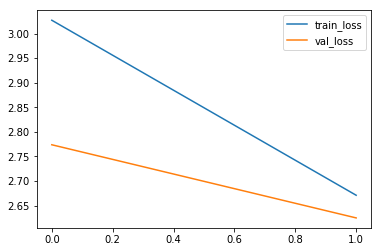

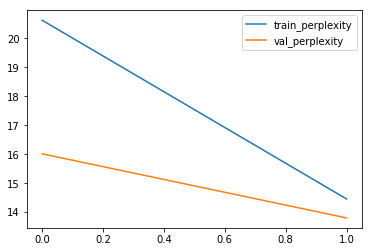

In [22]:
train_state_df = pd.DataFrame(train_state)
train_state_df.filter(regex='(train|val)_loss').plot()
train_state_df.filter(regex='(train|val)_perplexity').plot()
plt.show()

In [23]:
lm_dataset.set_data_type('test')
lm_dataset._target_df.head(), len(lm_dataset)

(                word data_type
 11000    мальтийский      test
 11001     расчленить      test
 11002       лопаться      test
 11003  индексировать      test
 11004  своевременный      test, 1000)

In [24]:
batch_generator = generate_batches(dataset=lm_dataset, 
                                   batch_size=2,
                                   collate_fn=collate_fn,
                                   shuffle=False,
                                   drop_last=False,
                                   device=args.device)
for batch_dict in islice(batch_generator, 1):
    pass

batch_dict

{'source_batch': tensor([[ 2, 29,  5,  6, 21, 17, 11, 12,  9, 10, 11, 12],
         [ 2, 18,  5,  9, 15,  6, 13,  8, 11, 17, 21,  0]]),
 'target_batch': tensor([[29,  5,  6, 21, 17, 11, 12,  9, 10, 11, 12,  3],
         [18,  5,  9, 15,  6, 13,  8, 11, 17, 21,  3,  0]]),
 'batch_lengths': tensor([12, 11])}

In [25]:
source_batch = batch_dict['source_batch']
target_batch = batch_dict['target_batch']
batch_lengths = batch_dict['batch_lengths']

source_batch, target_batch, batch_lengths

(tensor([[ 2, 29,  5,  6, 21, 17, 11, 12,  9, 10, 11, 12],
         [ 2, 18,  5,  9, 15,  6, 13,  8, 11, 17, 21,  0]]),
 tensor([[29,  5,  6, 21, 17, 11, 12,  9, 10, 11, 12,  3],
         [18,  5,  9, 15,  6, 13,  8, 11, 17, 21,  3,  0]]),
 tensor([12, 11]))

In [26]:
indices = torch.full((source_batch.shape[0], 1),
                     vectorizer.char_vocab.begin_index,
                     dtype=torch.int64)
h_t = None

indices = [indices]
indices

[tensor([[2],
         [2]])]

In [27]:
model.eval()
h_t = torch.zeros(1, source_batch.shape[0], args.hidden_size)
print(h_t.shape)

torch.Size([1, 2, 3])


In [28]:
probs = []
with(torch.no_grad()):
    for time_step in range(source_batch.shape[1]):
        x_t = source_batch[:, time_step].unsqueeze(1)
#         print(x_t.shape)
        emb_t = model.embedding(x_t)
#         print(emb_t.shape)
        rnn_out_t, h_t = model.rnn(emb_t, h_t)
#         print(rnn_out_t.shape, h_t.shape)
#         print(rnn_out_t.shape)
        y_pred = model.fc1(rnn_out_t.squeeze(1))
#         print(y_pred.shape)
        y_pred_proba = F.softmax(y_pred, dim=1)
#         print(y_pred_proba.shape)
        y_true_proba = y_pred_proba[range(source_batch.shape[0]), 
                                          target_batch[:, 0]]
        probs.append(y_true_proba)
probs = torch.stack(probs, dim=1)
probs

tensor([[0.0454, 0.0195, 0.0213, 0.0079, 0.0092, 0.0011, 0.0164, 0.0020, 0.0032,
         0.0049, 0.0181, 0.0016],
        [0.0906, 0.0760, 0.0649, 0.0685, 0.0396, 0.0286, 0.0237, 0.0228, 0.0186,
         0.0128, 0.0053, 0.0316]])

In [29]:
target_batch

tensor([[29,  5,  6, 21, 17, 11, 12,  9, 10, 11, 12,  3],
        [18,  5,  9, 15,  6, 13,  8, 11, 17, 21,  3,  0]])

In [44]:
for sample_idx in range(target_batch.shape[0]):
    word_prob = 1
    for time_step in range(batch_lengths[sample_idx]):
        char = vectorizer.char_vocab.lookup_index(target_batch[sample_idx, time_step].item())
        char_prob = probs[sample_idx, time_step]
        print(f'{char}: {char_prob}')
        word_prob *= char_prob
    print(f'Word propability: {word_prob}')

м: 0.04542377218604088
а: 0.01947995088994503
л: 0.021266799420118332
ь: 0.007854786701500416
т: 0.009223837405443192
и: 0.001107070012949407
й: 0.016374735161662102
с: 0.0019611262250691652
к: 0.0032304723281413317
и: 0.004923509433865547
й: 0.01813102327287197
<END>: 0.001570182852447033
Word propability: 2.1947624934556815e-26
р: 0.09061463177204132
а: 0.07604116946458817
с: 0.06489808857440948
ч: 0.06847822666168213
л: 0.03961785137653351
е: 0.028586266562342644
н: 0.023708298802375793
и: 0.022808272391557693
т: 0.018595276400446892
ь: 0.012797767296433449
<END>: 0.005268452223390341
Word propability: 2.3512160579927808e-17


In [39]:
vectorizer.char_vocab.lookup_index(29)

'м'

In [128]:
with torch.no_grad():
    for time_step in range(source_batch.shape[1]):
        x_t = source_batch[:, time_step]
        print(x_t)
        x_emb_t = model.embedding(x_t).unsqueeze(1)
        print(x_emb_t.shape)
        rnn_out_t, h_t = model.rnn(x_emb_t, h_t)
        print(rnn_out_t.shape, h_t.shape)
        y_pred = model.fc1(rnn_out_t)
        print(y_pred.shape)
        y_pred_proba = F.softmax(y_pred, dim=2, dtype=torch.int64).squeeze(1)
        print(y_pred_proba.shape)
        probs = y_pred_proba[range(source_batch.shape[0]), target_batch[:, 0]].unsqueeze(1)
        print(target_batch.shape)
        indices.append(probs)
        print(indices)

tensor([2, 2])
torch.Size([2, 1, 5])


RuntimeError: Expected hidden size (1, 2, 3), got (1, 1, 3)

In [218]:
y_pred_proba.shape, target_batch.shape

(torch.Size([2, 56]), torch.Size([2, 12]))

In [227]:
probs = torch.zeros_like(target_batch)
probs

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [248]:
y_pred_proba[range(len(source_batch)), target_batch[:, 0]].unsqueeze(1)

tensor([[0.0364],
        [0.0847]], grad_fn=<UnsqueezeBackward0>)

In [238]:
probs[:, 0] = y_pred_proba[range(len(source_batch)), target_batch[:, 0]].unsqueeze(1)
probs

RuntimeError: expand(torch.FloatTensor{[2, 1]}, size=[2]): the number of sizes provided (1) must be greater or equal to the number of dimensions in the tensor (2)

In [200]:
y_pred_proba[range(len(source_batch)), target_batch[:, 0]]

RuntimeError: index 29 is out of bounds for dim with size 1

In [185]:
y_pred.shape

torch.Size([2, 1, 56])

In [193]:
target_batch.unsqueeze(1)

tensor([[[29,  5,  6, 21, 17, 11, 12,  9, 10, 11, 12,  3]],

        [[18,  5,  9, 15,  6, 13,  8, 11, 17, 21,  3,  0]]])

In [195]:
idx = range(len(source_batch))
y_pred_proba.gather(dim=2, index=target_batch.unsqueeze(1))

tensor([[[3.6059e-02, 7.0550e-02, 3.3150e-02, 5.1875e-07, 1.5935e-02,
          2.4803e-02, 3.3445e-04, 8.4979e-02, 3.4252e-02, 2.4803e-02,
          3.3445e-04, 4.1297e-04]],

        [[8.5163e-02, 7.0550e-02, 8.4979e-02, 8.2856e-03, 3.3150e-02,
          3.5834e-02, 3.3697e-02, 2.4803e-02, 1.5935e-02, 5.1875e-07,
          4.1297e-04, 6.4077e-05]]], grad_fn=<GatherBackward>)